In [1]:
import pyvisa
import matplotlib.pyplot as plt
from time import sleep, time
from instruments import *

In [2]:
rm = pyvisa.ResourceManager()
lr = rm.list_resources()
for r in lr:
    if "awg" in r:
        AWG = ArbitraryWaveformGenerator(r)
    elif "daq" in r:
        DAQ = DataAcquisition(r)
    elif "172.31.182.32" in r:
        SMU = SourceMeasureUnit(r)
    elif "osc" in r:
        OSC = Oscilloscope(r)

In [3]:
AWG.connect()
DAQ.connect()
SMU.connect()
OSC.connect()

In [8]:
AWG.reset()
SMU.reset()
DAQ.reset()
OSC.reset()

In [4]:
#OSC.write("SYST:DISP:UPD 1")

In [5]:
def my_wf(V, n, T, DCYC, const_read=False, read_V=.1):
    if not len(V) == len(n) == len(T):
        raise RuntimeError("Inputs of get_Vt have different lengths.")
    for i in range(len(V)):
        if i == 0:
            n_read = round(T[i]*(1-DCYC[i]))
            n_zeros = T[i]//2
            wf = [0 for j in range(n_zeros)] + [(read_V if const_read else 0) for j in range(n_read)]
        for j in range(n[i]):
            wf += [V[i] for k in range(round(T[i]*DCYC[i]))]
            wf += [(read_V if const_read else 0) for k in range(round(T[i]*(1-DCYC[i])))]
    wf += [0 for j in range(n_zeros)]
    return wf, n_zeros, n_read

In [11]:
V, VOLT, n, T_AWG, DCYC, const_read, read_V, ch_AWG, SRAT_AWG = [1], 1, [10], [10**3], [.1], True, .1, 1, 1e7
wf_AWG, n_zeros, n_read = my_wf(V, n, T_AWG, DCYC, const_read, read_V)
V, VOLT, n, T_SMU, DCYC, const_read, read_V, ch_SMU, SRAT_SMU = [0], 1, [0], [10**2], [0], True, .1, 1, 1e3
wf_SMU, n_zeros, n_read = my_wf(V, n, T_SMU, DCYC, const_read, read_V)

In [12]:
SRAT_OSC = SRAT_AWG
t_scale = T_AWG[0]/SRAT_AWG*2
t_pos = T_AWG[0]/SRAT_AWG*8
chs = [1, 2]
scales = [VOLT/5, read_V*VOLT/5]
trig_source = 1
trig_level = read_V*VOLT*.9

In [13]:
AWG.set_wf(wf_AWG, SRAT_AWG, VOLT, ch_AWG)
SMU.set_wf(wf_SMU, SRAT_SMU, VOLT, ch_SMU)
DAQ.set_conn(123)
OSC.configure(SRAT_OSC, t_scale, t_pos, chs, scales, trig_source, trig_level)

In [14]:
DAQ.set_conn(113)
AWG.set_outp(1, ch_AWG)
AWG.trigger()
AWG.set_outp(0, ch_AWG)

In [10]:
DAQ.set_conn(113)
AWG.set_outp(1, ch_AWG)
AWG.trigger()
AWG.set_outp(0, ch_AWG)
DAQ.set_conn(111)
SMU.set_outp(1, ch_SMU)
SMU.trigger()
SMU.set_outp(0, ch_SMU)

In [46]:
DAQ.set_conn(111)
SMU.set_outp(1, ch_SMU)
SMU.trigger()
SMU.set_outp(0, ch_SMU)

In [40]:
V_i = np.array(SMU.query(f':fetc:arr:volt? (@{ch_SMU})').strip().split(',')).astype('float')
I_o = np.array(SMU.query(f':fetc:arr:curr? (@{ch_SMU})').strip().split(',')).astype('float')
t = np.array(SMU.query(f':fetc:arr:time? (@{ch_SMU})').strip().split(',')).astype('float')

In [66]:
R = V_i / I_o
t_ = np.concatenate([np.expand_dims(t[n_zeros:n_zeros+n_read], 0), np.reshape(t[n_zeros+n_read:-n_zeros-1], (np.sum(n), T_SMU[0]))[:, round(T_SMU[0]*DCYC[0]):]])
R_ = np.concatenate([np.expand_dims(R[n_zeros:n_zeros+n_read], 0), np.reshape(R[n_zeros+n_read:-n_zeros-1], (np.sum(n), T_SMU[0]))[:, round(T_SMU[0]*DCYC[0]):]])
a = np.mean(t_, 1)
b = np.mean(R_, 1)

C:\Users\oscar\AppData\Local\Temp\ipykernel_3976\1771121286.py:1: RuntimeWarning: divide by zero encountered in divide
  R = V_i / I_o


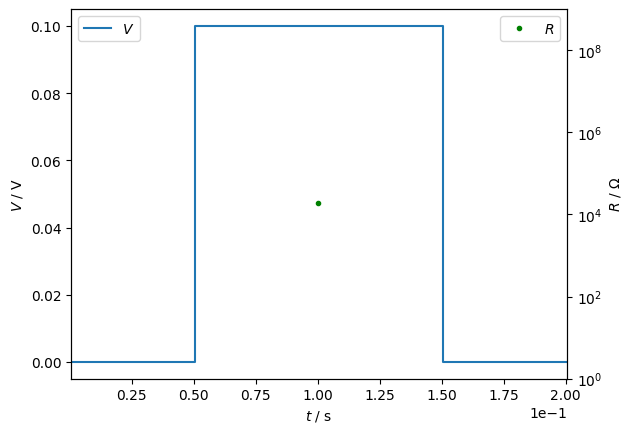

In [67]:
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()
ax0.step(t, V_i, where='post')
ax0.set_xlim(t[0], t[-1])
ax0.set_xlabel("$t$ / s")
ax0.set_ylabel("$V$ / V")
ax1.semilogy(a, b, 'g.')
ax1.set_ylim([1, 1e9])
ax1.set_ylabel("$R$ / $\Omega$")
ax0.legend(["$V$"], loc="upper left")
ax1.legend(["$R$"], loc="upper right")
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.show()

In [15]:
for ch_OSC in [1, 2]:
    f = open(f"wf{ch_OSC}.csv", "w")
    f.write(OSC.get_wf(ch_OSC))
    f.close()

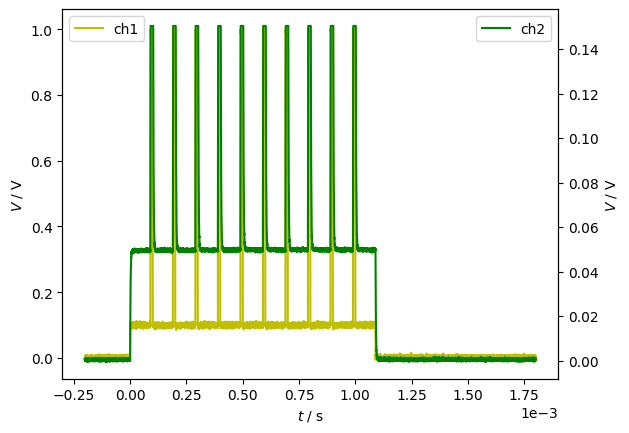

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel("$t$ / s")
wf1 = np.transpose(np.loadtxt("wf1.csv", delimiter=";"))
ax1.plot(wf1[0], wf1[1], "y")
ax1.set_ylabel("$V$ / V")
ax1.legend(["ch1"], loc="upper left")
wf2 = np.transpose(np.loadtxt("wf2.csv", delimiter=";"))
ax2.plot(wf2[0], wf2[1], "g")
ax2.set_ylabel("$V$ / V")
ax2.legend(["ch2"], loc="upper right")
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.show()

C:\Users\oscar\AppData\Local\Temp\ipykernel_14016\1606002526.py:1: RuntimeWarning: divide by zero encountered in divide
  R = 10e3*(wf1[1]-wf2[1])/wf2[1]
C:\Users\oscar\AppData\Local\Temp\ipykernel_14016\1606002526.py:1: RuntimeWarning: invalid value encountered in divide
  R = 10e3*(wf1[1]-wf2[1])/wf2[1]


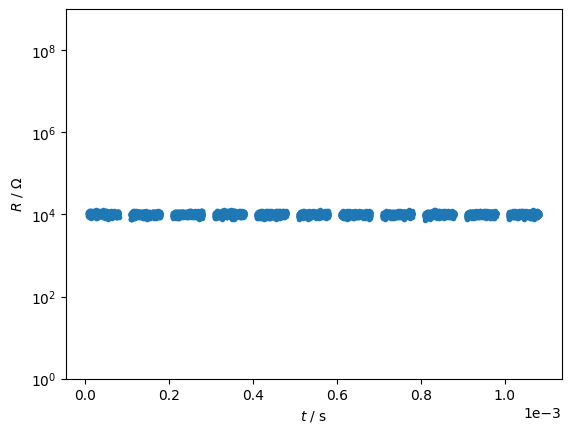

In [17]:
R = 10e3*(wf1[1]-wf2[1])/wf2[1]
SRAT_OSC = OSC.get_srat()
n_ones = round(SRAT_OSC / SRAT_AWG * T_AWG[0])//5
new_func = np.convolve(wf1[1], np.ones(n_ones)/n_ones, "same")
valid = np.logical_and(read_V * .9 < new_func, new_func < read_V * 1.1)
plt.semilogy(wf2[0, valid], R[valid], '.')
plt.ylim([1, 1e9])
plt.xlabel("$t$ / s")
plt.ylabel("$R$ / $\Omega$")
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.show()